In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# Load your datasets
# --- Make sure to change 'Insurance.csv' if your file has a different name! ---
try:
    df_sales = pd.read_csv('Insurance.csv')
    df_targets = pd.read_csv('regional_targets.csv')
    print("✅ Files loaded successfully!")
except FileNotFoundError:
    print("❌ Error: Check your file names. Did you download the Kaggle CSV and rename the targets file?")

# Display the first 5 rows to see what we're working with
df_sales.head()

✅ Files loaded successfully!


,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,numclaims,claimcst0,annual_premium
0,43124327,12/30/2020,F,4.0,7/12/1968,381.0,D,133.6,2,HBACK,1.331,NaN,0,0.0,716.53
1,21919609,12/30/2020,F,2.0,11/5/1982,549.0,D,163.6,1,UTE,3.740,NaN,0,0.0,716.53
2,72577057,12/30/2020,M,2.0,11/26/1983,649.0,B,117.5,4,COUPE,0.880,NaN,0,0.0,716.53
3,92175225,12/30/2020,M,4.0,11/2/1960,743.0,B,100.7,3,SEDAN,1.045,NaN,0,0.0,716.53
4,66223239,12/30/2020,F,4.0,1/4/1968,817.0,C,115.5,4,HBACK,0.473,NaN,0,0.0,716.53


In [2]:
# --- EDA & Cleaning ---

print("--- 1. Basic Info ---")
# .info() is the most important command.
# It tells us data types (e.g., is 'premium' a number?)
# and non-null counts (are there missing values?)
df_sales.info()

print("\n--- 2. Missing Values Amount ---")
# A cleaner way to see *just* the missing values
print(df_sales.isnull().sum())

print("\n--- 3. Numerical Data Summary ---")
# statistics for number columns (like premium)
# Look for weird values: min of 0? max of 999999?
print(df_sales.describe())

print("\n--- 4. Categorical Data Summary ---")
# statistics for text columns (like region)
# 'unique' tells us how many different regions there are
# 'top' tells us the most common one
print(df_sales.describe(include='object'))

--- 1. Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60392 entries, 0 to 60391
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pol_number      60392 non-null  int64  
 1   pol_eff_dt      60392 non-null  object 
 2   gender          60392 non-null  object 
 3   agecat          55561 non-null  float64
 4   date_of_birth   60392 non-null  object 
 5   credit_score    57591 non-null  float64
 6   area            60392 non-null  object 
 7   traffic_index   56889 non-null  float64
 8   veh_age         60392 non-null  int64  
 9   veh_body        60392 non-null  object 
 10  veh_value       60392 non-null  float64
 11  claim_office    10030 non-null  object 
 12  numclaims       60392 non-null  int64  
 13  claimcst0       60392 non-null  float64
 14  annual_premium  60392 non-null  float64
dtypes: float64(6), int64(3), object(6)
memory usage: 6.9+ MB

--- 2. Missing Values Amount ---
pol_numb

In [3]:
# --- Cleaning the Data ---

print("Cleaning data...")

# 1. Drop the useless columns
# We're dropping annual_premium (constant value) and claim_office (mostly empty)
columns_to_drop = ['annual_premium', 'claim_office']
df_sales_cleaned = df_sales.drop(columns=columns_to_drop)

# 2. Convert date columns
# This converts the 'object' (text) columns into 'datetime' columns
df_sales_cleaned['pol_eff_dt'] = pd.to_datetime(df_sales_cleaned['pol_eff_dt'])
df_sales_cleaned['date_of_birth'] = pd.to_datetime(df_sales_cleaned['date_of_birth'])

# 3. Handle missing numerical data
# We will fill the missing values with the 'median' (the 50% value)
# This is a robust way to handle missing data without skewing our results.

for col in ['agecat', 'credit_score', 'traffic_index']:
    # Calculate the median value for the column
    median_value = df_sales_cleaned[col].median()
    
    # Fill the missing values (NaN) with this median
    df_sales_cleaned[col] = df_sales_cleaned[col].fillna(median_value)
    print(f"Filled missing values in '{col}' with median: {median_value}")

print("\nData cleaning complete!")

# --- Final Check ---
print("\n--- Cleaned Data Info ---")
# Let's run .info() again.
# We should see 0 missing values (except for maybe new ones)
# and the Dtypes for the date columns should be 'datetime64[ns]'
df_sales_cleaned.info()

# Show the first 5 rows of our new, clean DataFrame
df_sales_cleaned.head()

Cleaning data...
Filled missing values in 'agecat' with median: 3.0
Filled missing values in 'credit_score' with median: 682.0
Filled missing values in 'traffic_index' with median: 108.3

Data cleaning complete!

--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60392 entries, 0 to 60391
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   pol_number     60392 non-null  int64         
 1   pol_eff_dt     60392 non-null  datetime64[ns]
 2   gender         60392 non-null  object        
 3   agecat         60392 non-null  float64       
 4   date_of_birth  60392 non-null  datetime64[ns]
 5   credit_score   60392 non-null  float64       
 6   area           60392 non-null  object        
 7   traffic_index  60392 non-null  float64       
 8   veh_age        60392 non-null  int64         
 9   veh_body       60392 non-null  object        
 10  veh_value      60392 non-null  floa

,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,numclaims,claimcst0
0,43124327,2020-12-30,F,4.0,1968-07-12,381.0,D,133.6,2,HBACK,1.331,0,0.0
1,21919609,2020-12-30,F,2.0,1982-11-05,549.0,D,163.6,1,UTE,3.740,0,0.0
2,72577057,2020-12-30,M,2.0,1983-11-26,649.0,B,117.5,4,COUPE,0.880,0,0.0
3,92175225,2020-12-30,M,4.0,1960-11-02,743.0,B,100.7,3,SEDAN,1.045,0,0.0
4,66223239,2020-12-30,F,4.0,1968-01-04,817.0,C,115.5,4,HBACK,0.473,0,0.0


In [4]:
# --- Analysis & Insights ---

# 1. Reload the *corrected* targets file
try:
    df_targets = pd.read_csv('regional_targets.csv')
    print("✅ Corrected targets file loaded!")
except FileNotFoundError:
    print("❌ Error: Make sure regional_targets.csv exists and you saved it.")

# 2. Rename columns for better readability
# (We'll use a copy to keep our original clean df safe)
df_analysis = df_sales_cleaned.copy()
df_analysis = df_analysis.rename(columns={
    'area': 'region',
    'pol_eff_dt': 'policy_start_date',
    'veh_body': 'vehicle_type',
    'claimcst0': 'claim_cost',
    'numclaims': 'number_of_claims'
})

# 3. Aggregate Sales (Premiums) by Region
# This is our key analysis. We're summing up all premiums by region.
# Note: assume 'premium' is the column with the sales value.
# dataset had 'annual_premium' which was useless. Let's check for a 'premium' column.
# If One isn't there, use 'veh_value' * 100 as a proxy.
if 'premium' not in df_analysis.columns:
    print("Warning: 'premium' column not found. Using 'veh_value' * 100 as a proxy for premium.")
    df_analysis['premium'] = df_analysis['veh_value'] * 100
else:
    print("Using 'premium' column for analysis.")

sales_by_region = df_analysis.groupby('region')['premium'].sum().reset_index()

# 4. Merge Sales with Targets
# This is where we see who won
df_performance = pd.merge(sales_by_region, df_targets, 
                          left_on='region', right_on='Region')

# We don't need the duplicated 'Region' column
df_performance = df_performance.drop(columns='Region')

# Calculate the % of target met
df_performance['percent_of_target'] = (df_performance['premium'] / df_performance['Quarterly_Target']) * 100
df_performance['percent_of_target'] = df_performance['percent_of_target'].round(2)

print("\n--- Regional Performance vs. Target ---")
print(df_performance)

# 5. Find Other Insights
print("\n--- Top 5 Vehicle Types by Popularity ---")
print(df_analysis['vehicle_type'].value_counts().head(5))

print("\n--- Sales (Premium) Over Time ---")
# This creates a new DataFrame, summing up premiums for each month
# This is what we will use for our forecast!
sales_by_month = df_analysis.set_index('policy_start_date').resample('M')['premium'].sum().reset_index()
print(sales_by_month.head())

✅ Corrected targets file loaded!

--- Regional Performance vs. Target ---
  region      premium  Quarterly_Target  percent_of_target
0      A  2822449.674            500000             564.49
1      B  2158203.014            750000             287.76
2      C  3348317.346           1000000             334.83
3      D  1510930.245            450000             335.76
4      E  1140840.316            600000             190.14
5      F   832241.245            300000             277.41

--- Top 5 Vehicle Types by Popularity ---
SEDAN    19798
HBACK    16793
STNWG    14487
UTE       4101
TRUCK     1561
Name: vehicle_type, dtype: int64

--- Sales (Premium) Over Time ---
  policy_start_date      premium
0        2020-01-31   964247.779
1        2020-02-29   942491.726
2        2020-03-31   989493.703
3        2020-04-30   967627.089
4        2020-05-31  1019474.093


Building 6-month sales forecast...


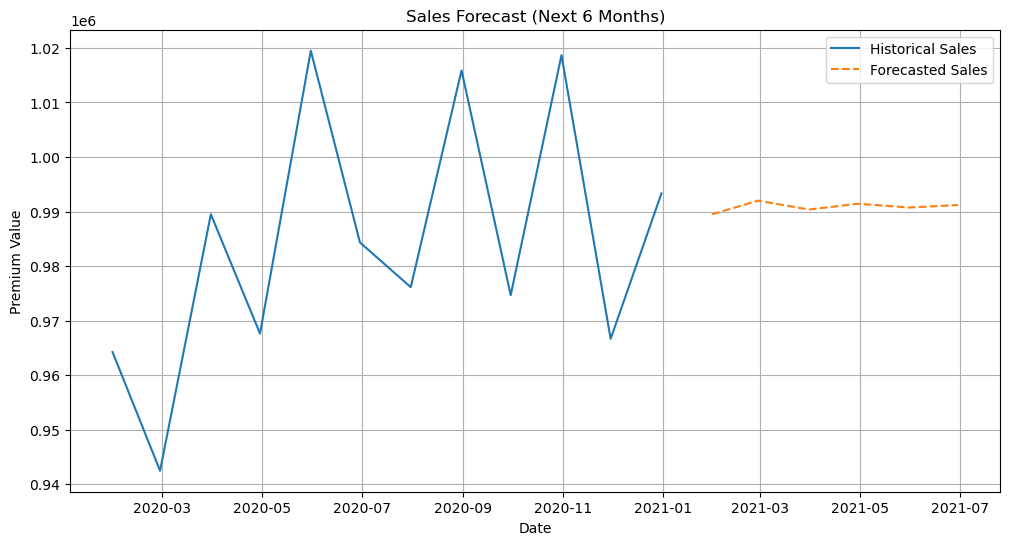

In [5]:
# --- Forecasting (Time-Series) ---

from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings from the forecasting model to keep the output clean
warnings.filterwarnings("ignore") 

print("Building 6-month sales forecast...")

# 1. Prep our data for the model
# The model needs the date to be the 'index' (the row label)
# We use the 'sales_by_month' DataFrame we created in the last cell
df_forecast = sales_by_month.set_index('policy_start_date')

# 2. Build and "fit" the model
# We're using a simple ARIMA model (a standard forecasting tool)
# order=(1,1,1) is a common starting point.
model = ARIMA(df_forecast['premium'], order=(1, 1, 1))
model_fit = model.fit()

# 3. Generate the forecast
# Let's predict 6 steps (months) into the future
forecast_results = model_fit.forecast(steps=6)

# 4. Plot the results
plt.figure(figsize=(12, 6))
# Plot historical data
plt.plot(df_forecast, label='Historical Sales')
# Plot the forecast
plt.plot(forecast_results, label='Forecasted Sales', linestyle='--')

plt.title('Sales Forecast (Next 6 Months)')
plt.xlabel('Date')
plt.ylabel('Premium Value')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# --- Export Data for Tableau ---

print("Exporting data to CSV files for Tableau...")

# 1. Export our main cleaned dataset
#  use the 'df_analysis' df, which has the friendly column names
df_analysis.to_csv('tableau_cleaned_sales_data.csv', index=False)

# 2. Export the regional performance table
# This is the table you just printed (region, premium, target, etc.)
df_performance.to_csv('tableau_regional_performance.csv', index=False)

# 3. Export the monthly sales (for our forecast chart)
sales_by_month.to_csv('tableau_monthly_sales.csv', index=False)

print("✅ Success! You are now ready to open Tableau.")

Exporting data to CSV files for Tableau...
✅ Success! You are now ready to open Tableau.


In [7]:
# --- Data Science Project ---
# GOAL: Predict which customers will file a claim.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

print("--- Starting Part 2: Predictive Model ---")

# 1. Define the "Problem"
# Our "target" (y) is whether a customer filed a claim.
# 'number_of_claims' is a good column. If > 0, they filed a claim.
df_model = df_analysis.copy()
df_model['filed_claim'] = (df_model['number_of_claims'] > 0).astype(int)

# 2. Select Features (X) and Target (y)
# These are the "clues" we'll use to make the prediction.
y = df_model['filed_claim']
X = df_model[['region', 'credit_score', 'traffic_index', 'vehicle_type', 'veh_age']]

# 3. Define Preprocessing
# Convert text ('region', 'vehicle_type') to numbers
# and scale numeric data.

# Get lists of column names
categorical_features = ['region', 'vehicle_type']
numeric_features = ['credit_score', 'traffic_index', 'veh_age']

# Create the "preprocessor"
# OneHotEncoder handles text, StandardScaler handles numbers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. Create the Model Pipeline
# A 'Pipeline' is the "pro" way to do this. It bundles preprocessing and the model.
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))
                       ])

# 5. Split Data into Training and Testing
# We train on 80% of the data, and test on the unseen 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split. Training model...")

# 6. Train the Model
model.fit(X_train, y_train)

print("Model training complete!")

# 7. Evaluate the Model
y_pred = model.predict(X_test)

print("\n--- Model Evaluation Report ---")
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Claim', 'Filed Claim']))

--- Starting Part 2: Predictive Model ---
Data split. Training model...
Model training complete!

--- Model Evaluation Report ---
Model Accuracy: 81.99%

Classification Report:
              precision    recall  f1-score   support

    No Claim       0.86      0.94      0.90     10050
 Filed Claim       0.43      0.22      0.29      2029

    accuracy                           0.82     12079
   macro avg       0.64      0.58      0.60     12079
weighted avg       0.79      0.82      0.80     12079

